In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler

In [2]:
runs = ELPH_utils.load_runs()

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

100 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


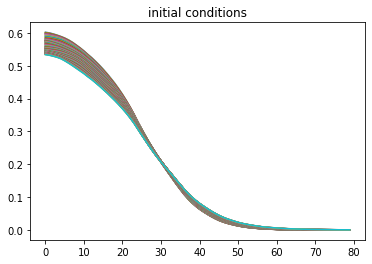

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('initial conditions')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39900)
NVAR state shape:  (861, 39900)
target shape:  (20, 39900)
weights shape:  (861, 20)


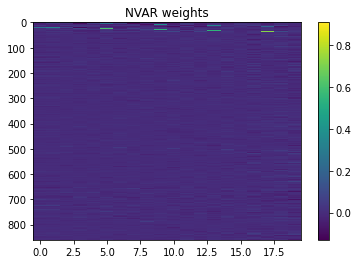

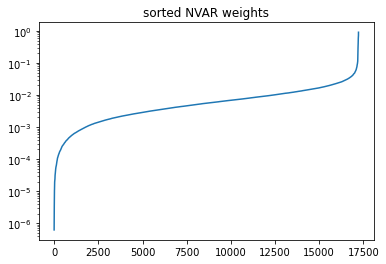

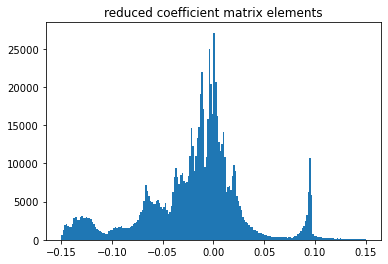

In [35]:
from ELPH_NVAR import SVDNVAR

# scaler = None
# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.3)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(alpha=10**-3.4, rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.red_coef_matrix), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

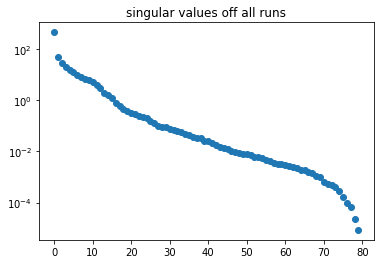

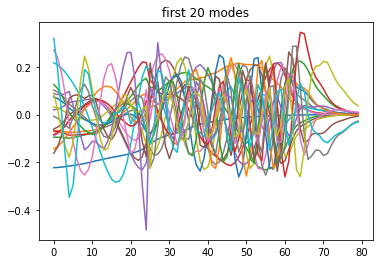

In [5]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [34]:
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_kwargs = {'alpha':10**-2.8, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'scaler':scaler, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.006961702327310556
0.00039679471504783844
[0.007180323123281043, 0.007619329660512694, 0.00678926274256231, 0.006731356320250559, 0.006488239789946173]


In [40]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    
    train_kwargs = {'alpha':alpha, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':True}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=10, n_iter=60)

In [41]:
scores = []

k = 1

for aExp in np.linspace(-5,-1,10):
    for rs in np.linspace(0.1,0.6,10):
        print(k)
        scores.append(get_score(aExp,rs))
        k += 1

1


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_NVAR.py:142: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


[0 1 2 3]
[[0 1]
 [2 3]]


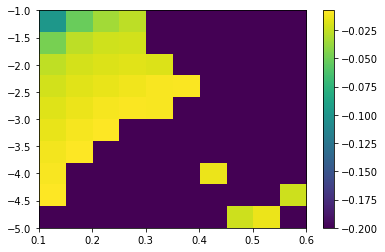

In [57]:
scrs = np.array(scores)
scrs = np.reshape(scrs,(10,10))


a = np.arange(4)
print(a)
print(np.reshape(a,(2,2)))

plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.2, extent=[0.1,0.6,-5,-1])
plt.colorbar()
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39501)
NVAR state shape:  (861, 39501)
target shape:  (20, 39501)
weights shape:  (861, 20)
NVAR error:  0.008183474958471049
NVAR error compared to SVD approximated run:  0.008375890243665862


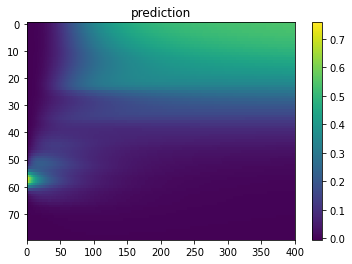

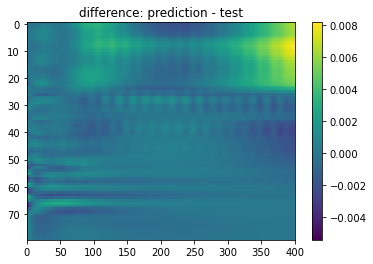

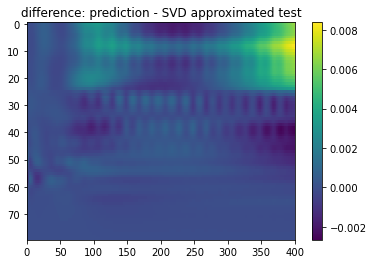

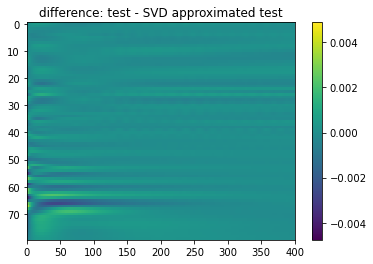

In [36]:
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_runs = runs[::1]
test_run = train_runs.pop(90)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='ridge', alpha=10.**-2.8, intercept=True, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

In [ ]:
#Multivariate multiple regression: Johnson and Wichern 2007